In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'
### DAVID : this is the path to my code and data folders, probably add yours

In [43]:
net = 'highd_inputs'
### DAVID : this directs to a folder within the code from github
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model
import tools
from tools_lnd import get_model_params, name_best_ckpt, plot_FP, plot_N, make_h_and_Jac, make_Jac, gen_trials_from_model_dir, gen_X_from_model_dir_epoch

In [4]:
fldr = os.path.join('vis_new_network/')
if not os.path.exists(fldr):
    os.makedirs(fldr)

In [48]:
dir_specific_all = 'highd_inputs/all_rules_4/softplus/no_reg_tune_width/'
model_n = 1
model_dir_all = os.path.join(p+'/data/rnn/multitask/crystals/',dir_specific_all,str(model_n))

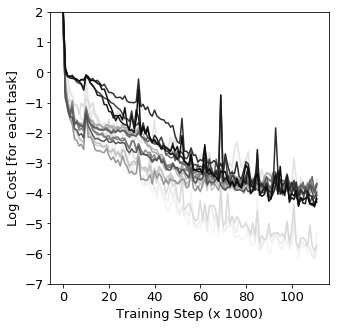

In [49]:
task_set= range (20)

fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(model_dir_all, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in task_set:
    c = cmap(r/20)
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+rules_dict['all'][r]])
    plt.plot(x,'-',c = c)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-7,2])
plt.show() 

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/ckpts/model.ckpt-110000


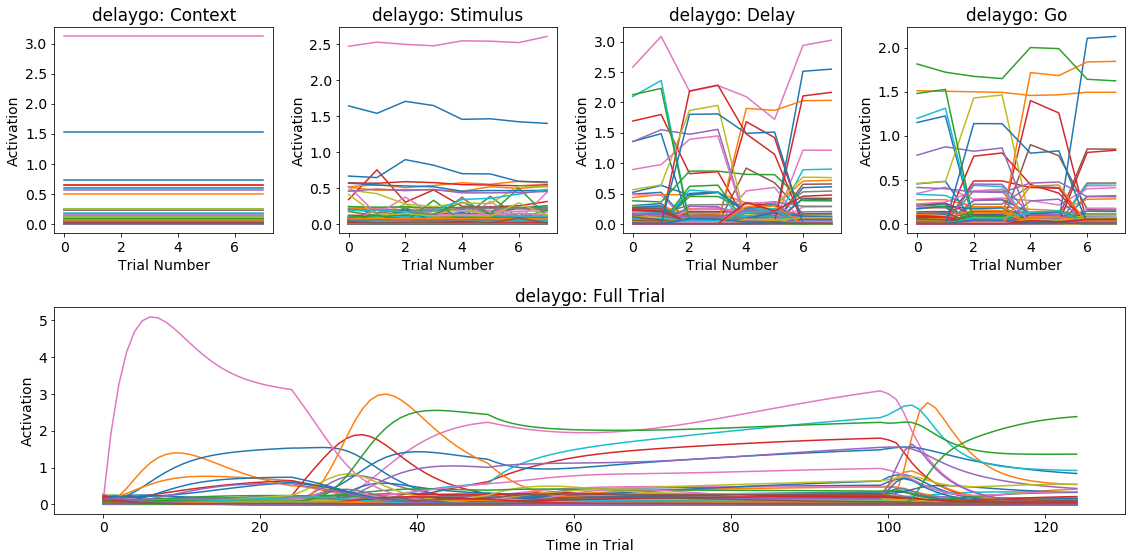

In [51]:
# Maybe useful [super basic] hidden unit activity visualization?
rule = 'delaygo'
model_n = 0
skip_trials = 1
model = Model(model_dir_all)
with tf.Session() as sess:

    ckpt_n = name_best_ckpt(model_dir_all,rule)
    ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))
    model.saver.restore(sess,ckpt_n_dir)
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='test', noise_on=False, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        
fig = plt.figure(figsize=(16, 8),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 14})

trial_set = range(0,np.shape(h_tf)[1],skip_trials)

ax1 = plt.subplot(2,4,1)
plt.plot(h_tf[trial.epochs['stim1'][0]-1,trial_set,:]) # Every other trial to exclude modality 2
plt.title(rule + ': Context')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,2)
plt.plot(h_tf[trial.epochs['stim1'][0]+1,trial_set,:])
plt.title(rule + ': Stimulus')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,3)
plt.plot(h_tf[trial.epochs['go1'][0]-1,trial_set,:])
plt.title(rule + ': Delay')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,4,4)
plt.plot(h_tf[trial.epochs['go1'][0]+10,trial_set,:])
plt.title(rule + ': Go')
plt.xlabel('Trial Number')
plt.ylabel('Activation')

ax1 = plt.subplot(2,1,2)
plt.plot(h_tf[:,1,:])
plt.title(rule + ': Full Trial')
plt.xlabel('Time in Trial')
plt.ylabel('Activation')

plt.savefig('sfn/for_David/simple_trial_example.svg')
plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' sh

<Figure size 360x360 with 0 Axes>

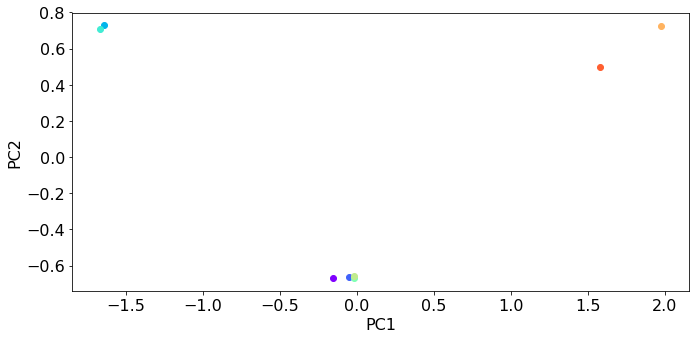

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' sh

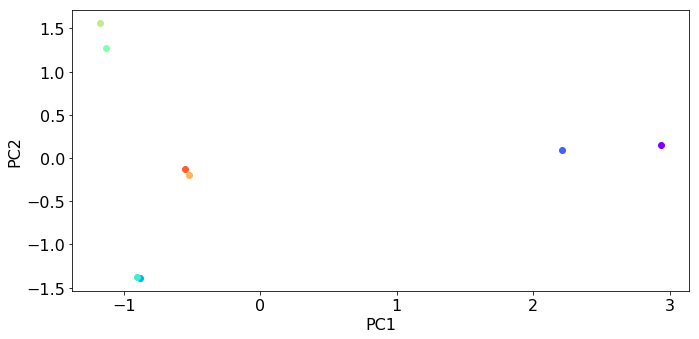

In [52]:
fig = plt.figure(figsize=(5, 5),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})
file_name = 'pca on go period'
epoch = 'go1'

for rule1_ind in range(len(rule_list)):
        rule1 = rule_list[rule1_ind]

        #MULTI
        model = Model(model_dir_all)
        ckpt_n = name_best_ckpt(model_dir_all,'delaygo')
        ckpt_n_dir = os.path.join(model_dir_all,'ckpts/model.ckpt-' + str(int(ckpt_n)))

        trial1 = gen_trials_from_model_dir(model_dir_all,rule1)
        X,x = gen_X_from_model_dir_epoch(model_dir_all,ckpt_n_dir,trial1,epoch)

        N,S,T = np.shape(x) # neurons x trials (stim)  
        pca = PCA()
        X_pca = pca.fit_transform(x[:,:,-1].T)

        n_pcs = 5
        cmap=plt.get_cmap('rainbow')
        fig = plt.figure(figsize=(10, 5),tight_layout=True,facecolor='white')
        pc1 = 0
        pc2 = 2
        for t in range(S):
            c = cmap(t/S)
            plt.plot(X_pca[t,pc1],X_pca[t,pc2],'o',c = c)
            plt.xlabel('PC1')
            plt.ylabel('PC2')

        plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt


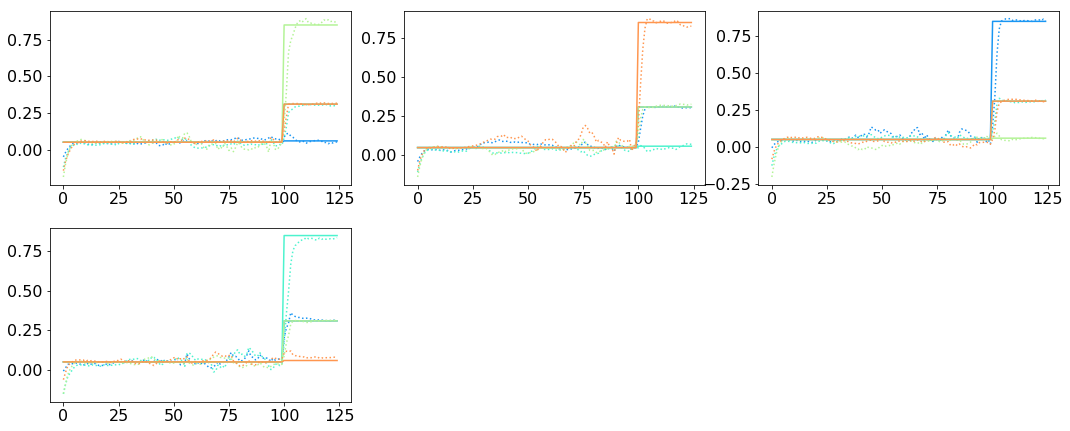

In [53]:
model = Model(model_dir_all)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    # get all connection weights and biases as tensorflow variables
    var_list = model.var_list
    # evaluate the parameters after training
    params = [sess.run(var) for var in var_list]
    w_out = params[2]
    hparams = model.hp
    feed_dict = tools.gen_feed_dict(model, trial1, hparams)
    # run model
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)

n_trials = 4
col = 3
row = 5
fig = plt.figure(figsize=(15, 15),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 16})

ind = 0
for t in range(0,np.shape(trial1.y)[1],int(np.shape(trial1.y)[1]/n_trials)):
    ind+=1
    plt.subplot(row,col,ind)
    for out_i in range(1,np.shape(trial1.y)[2]):
        c = cmap(out_i/np.shape(trial1.y)[2])
        plt.plot(trial1.y[:,t,out_i],c = c)
        plt.plot(y_hat_tf[:,t,out_i],':',c = c)
#         plt.ylim((0,.5))

plt.show()

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(285, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 5) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(5,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/crystals/highd_inputs/all_rules_4/softplus/no_reg_tune_width/1/model.ckpt


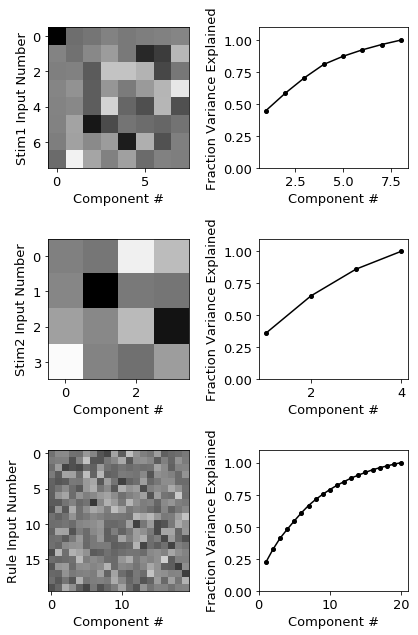

In [54]:
model_dir = model_dir_all#os.path.join('/home/laura/code/yangnet/data/n8/','all',str(model_n))
w_in, b_in, w_out, b_out = get_model_params(model_dir)

ni = hparams['n_eachring']

pca_stim1 = PCA()
pca_stim1.fit(w_in[:,1:2*ni+1])

pca_stim2 = PCA()
pca_stim2.fit(w_in[:,(ni+1):(2*ni+1)])

pca_rule = PCA()
pca_rule.fit(w_in[:,(2*ni+1):(2*ni+21)])

FONT_WEIGHT = 'bold'
fig = plt.figure(figsize=(6, 9),tight_layout=True,facecolor='white')
plt.rcParams.update({'font.size': 13})

ax = fig.add_subplot(3,2,1)
plt.imshow(pca_stim1.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Stim1 Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,2)
plt.plot(range(1,2*ni+1),np.cumsum(pca_stim1.explained_variance_)/np.sum(pca_stim1.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()

ax = fig.add_subplot(3,2,3)
plt.imshow(pca_stim2.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Stim2 Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,4)
plt.plot(range(1,ni+1),np.cumsum(pca_stim2.explained_variance_)/np.sum(pca_stim2.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()

ax = fig.add_subplot(3,2,5)
plt.imshow(pca_rule.components_.T,vmin=-1, vmax=1)
ax.set_ylabel('Rule Input Number')
ax.set_xlabel('Component #')
ax = fig.add_subplot(3,2,6)
plt.plot(range(1,21),np.cumsum(pca_rule.explained_variance_)/np.sum(pca_rule.explained_variance_),'-ok', markersize = 4)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Component #')
ax.set_ylabel('Fraction Variance Explained')
plt.gray()
plt.show()